## Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

### 1. Importing libraries and data

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [5]:
# Define path
path = r'C:\Users\16307\Desktop\Tasks - DA Immersion\Gun Violence Analysis'

In [6]:
# Import data
df = pd.read_csv(os.path.join(path, '02 Data', 'gun_violence_cleaned3.csv'))

### 2. Subsetting, wrangling, and cleaning time-series data

In [8]:
columns = ["date", "n_killed"]

In [9]:
# Create a subset
subset_df = df[columns]
subset_df

,date,n_killed
0,1/1/2013,0
1,1/1/2013,1
2,1/1/2013,1
3,1/5/2013,4
4,1/7/2013,2
...,...,...
239672,3/31/2018,0
239673,3/31/2018,1
239674,3/31/2018,0
239675,3/31/2018,1


In [10]:
# Ensure the 'date' column is in datetime format
subset_df['date'] = pd.to_datetime(subset_df['date'])

# Group by 'date' and sum the 'n_killed' values
subset_df2 = subset_df.groupby('date').sum().reset_index()

# Sort by 'date' in chronological order
subset_df2 = subset_df2.sort_values(by='date')

# View the aggregated DataFrame
print(subset_df2)

           date  n_killed
0    2013-01-01         2
1    2013-01-05         4
2    2013-01-07         6
3    2013-01-19         5
4    2013-01-21         0
...         ...       ...
1720 2018-03-27        18
1721 2018-03-28        42
1722 2018-03-29        33
1723 2018-03-30        41
1724 2018-03-31        53

[1725 rows x 2 columns]


In [11]:
subset_df3 = subset_df2.loc[(subset_df2['date'] >= '2014-01-01') & (subset_df2['date'] <= '2018-03-01')]

In [12]:
# Set the "date" column as the index

from datetime import datetime

subset_df3['datetime'] = pd.to_datetime(subset_df3['date']) # Create a datetime column from "date.""
subset_df3 = subset_df3.set_index('datetime') # Set the datetime as the index of the dataframe.
subset_df3.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
subset_df3 = subset_df3.asfreq('D') # Set frequency to daily
subset_df3.head()

,n_killed
datetime,
2014-01-01,50.0
2014-01-02,29.0
2014-01-03,37.0
2014-01-04,37.0
2014-01-05,31.0


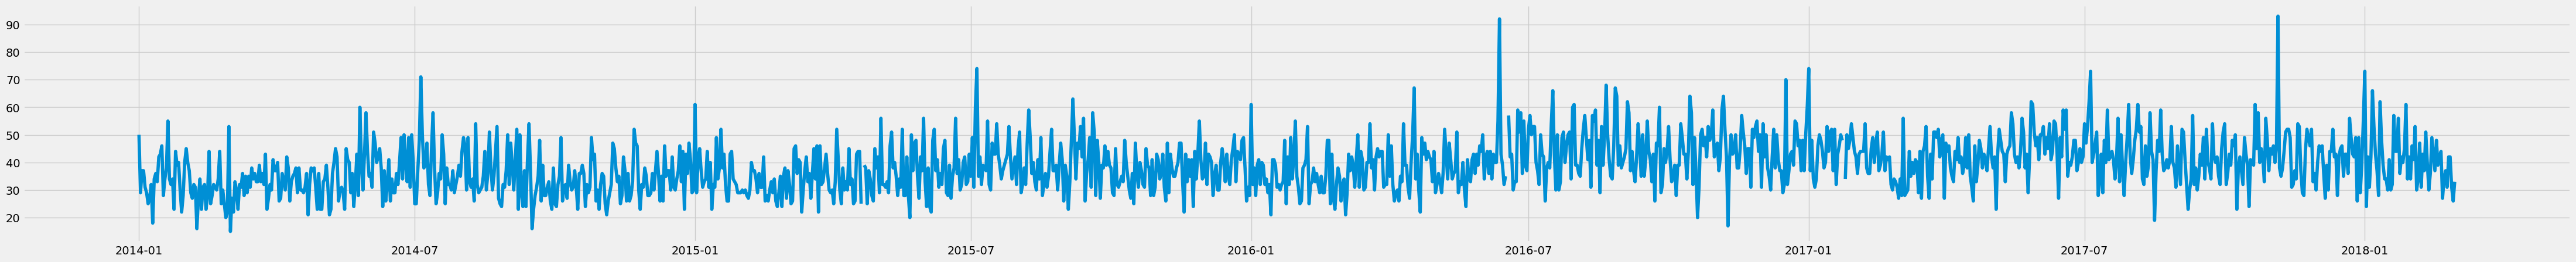

In [13]:
# Plot the data set

plt.figure(figsize=(50,5), dpi=100)
plt.plot(subset_df3)

In [14]:
# Check for missing values
subset_df3.isnull().sum() 

n_killed    3
dtype: int64

In [15]:
# Fill missing values
subset_df3.fillna(0, inplace=True)

In [16]:
# Check for duplicates

dups = subset_df3.duplicated()
dups.sum()

1461

### 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(subset_df3, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

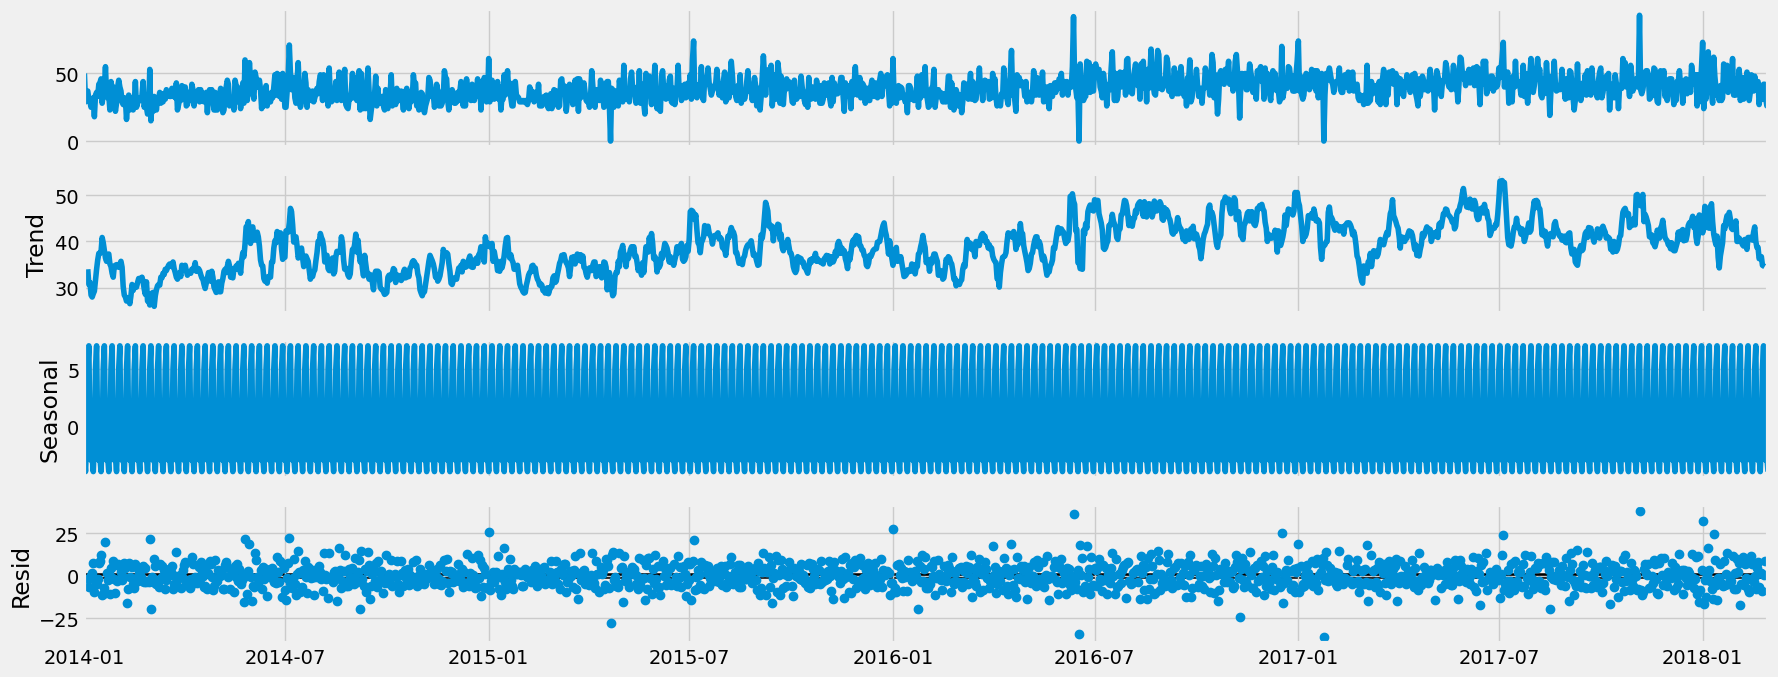

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

**Observation:**
- The seasonal plot indicates that the data follows a regular, repeating cycle.
- There is a slight annual trend of higher death counts for the months of January and July.

### 4. Testing for stationarity

In [23]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries):
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(subset_df3['n_killed'])

Dickey-Fuller Stationarity test:
Test Statistic                   -3.342612
p-value                           0.013078
Number of Lags Used              22.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64


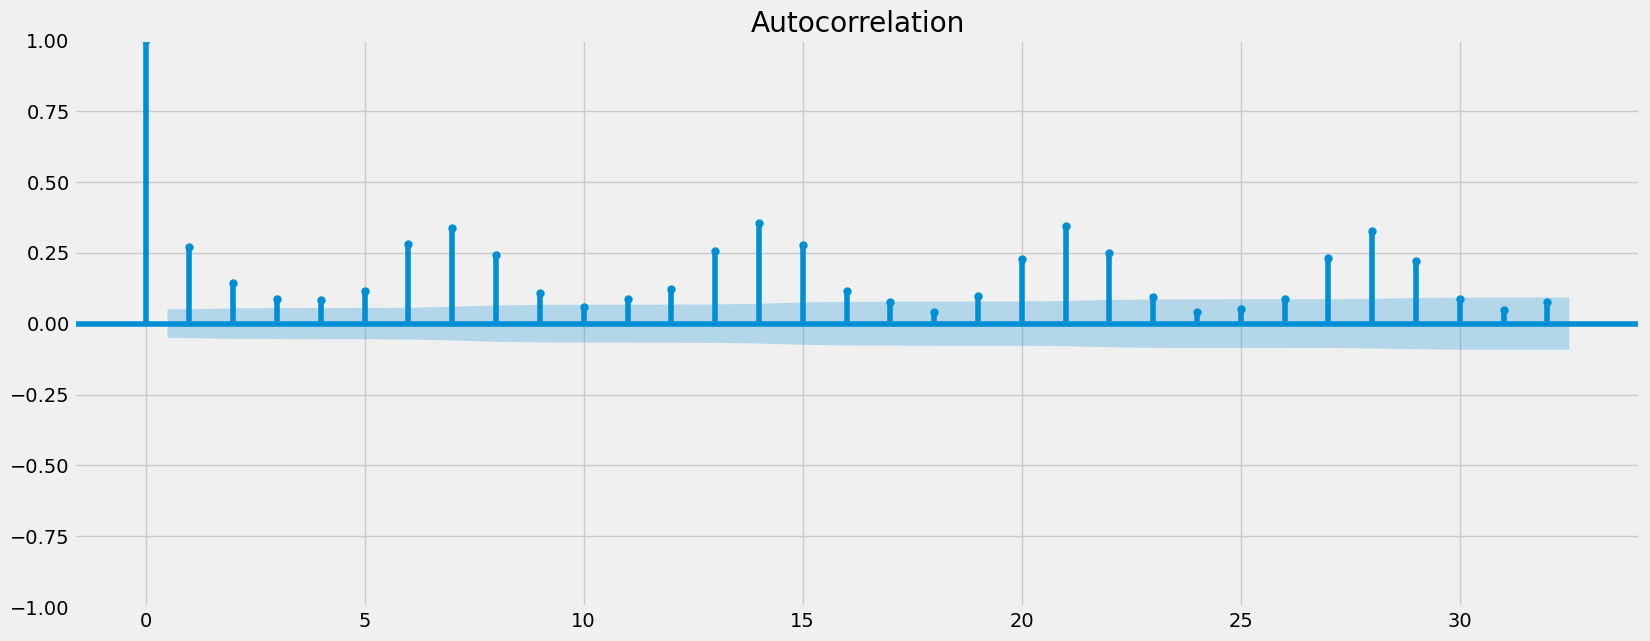

In [25]:
# Check out a plot of autocorrelations

# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(subset_df3)
plt.show()

### 5. Stationarizing the data

In [28]:
data_diff = subset_df3 - subset_df3.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [30]:
# Remove the missing values that came about as a result of the differencing
data_diff.dropna(inplace = True) 

In [32]:
data_diff.head()

,n_killed
datetime,
2014-01-02,-21.0
2014-01-03,8.0
2014-01-04,0.0
2014-01-05,-6.0
2014-01-06,-2.0


In [34]:
data_diff.columns

Index(['n_killed'], dtype='object')

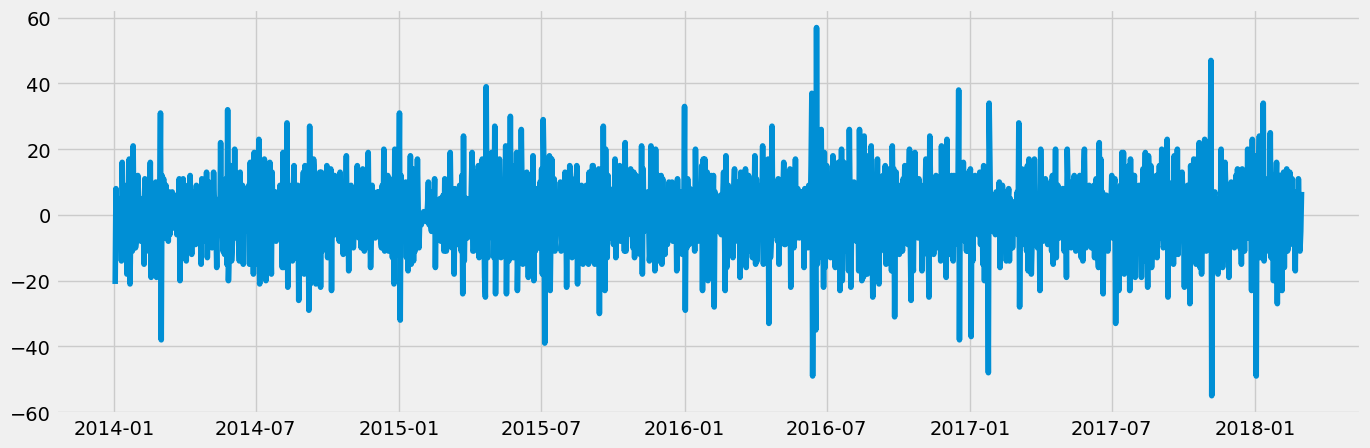

In [36]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [38]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.476727e+01
p-value                        2.352021e-27
Number of Lags Used            2.000000e+01
Number of Observations Used    1.499000e+03
Critical Value (1%)           -3.434720e+00
Critical Value (5%)           -2.863470e+00
Critical Value (10%)          -2.567798e+00
dtype: float64


**Observation:**
- The test statistic -14.76727 is smaller than the critical values of -3 and -2. 
- The p-value is also significantly smaller than 0.05 (p < 0.05).
- This means we can reject the null hypothesis and consider the series stationary.

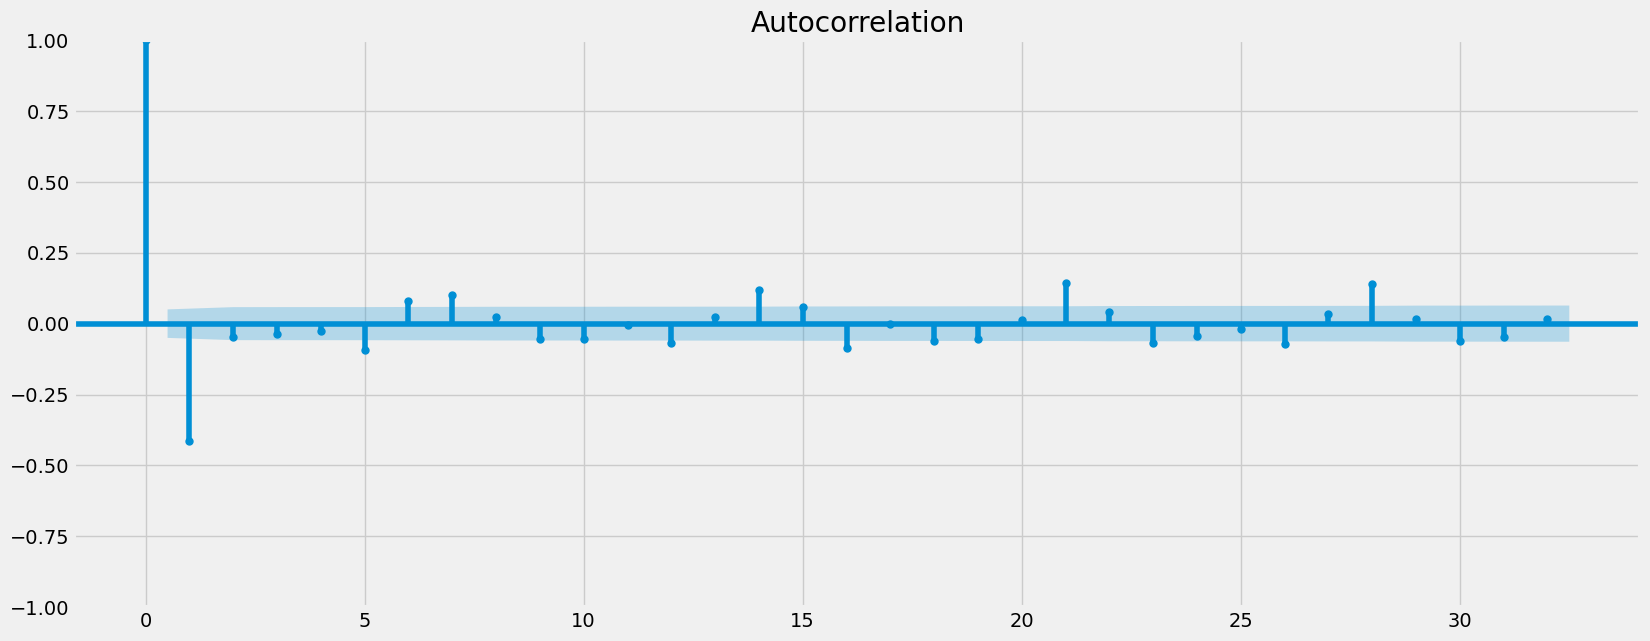

In [40]:
plot_acf(data_diff)
plt.show()

**Observation:**
While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect (more than 10 data points above or below the confidence interval). This means that, despite the Dickey-Fuller test saying that the data is stationary, that stationarity is weak.

In [47]:
# Conduct another round of differencing to stationarize data even further
data_diff2 = data_diff - data_diff.shift(1)

In [49]:
# Remove the missing values that came about as a result of the differencing
data_diff2.dropna(inplace = True) 

In [51]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.879971e+01
p-value                        2.022932e-30
Number of Lags Used            2.300000e+01
Number of Observations Used    1.495000e+03
Critical Value (1%)           -3.434732e+00
Critical Value (5%)           -2.863475e+00
Critical Value (10%)          -2.567800e+00
dtype: float64


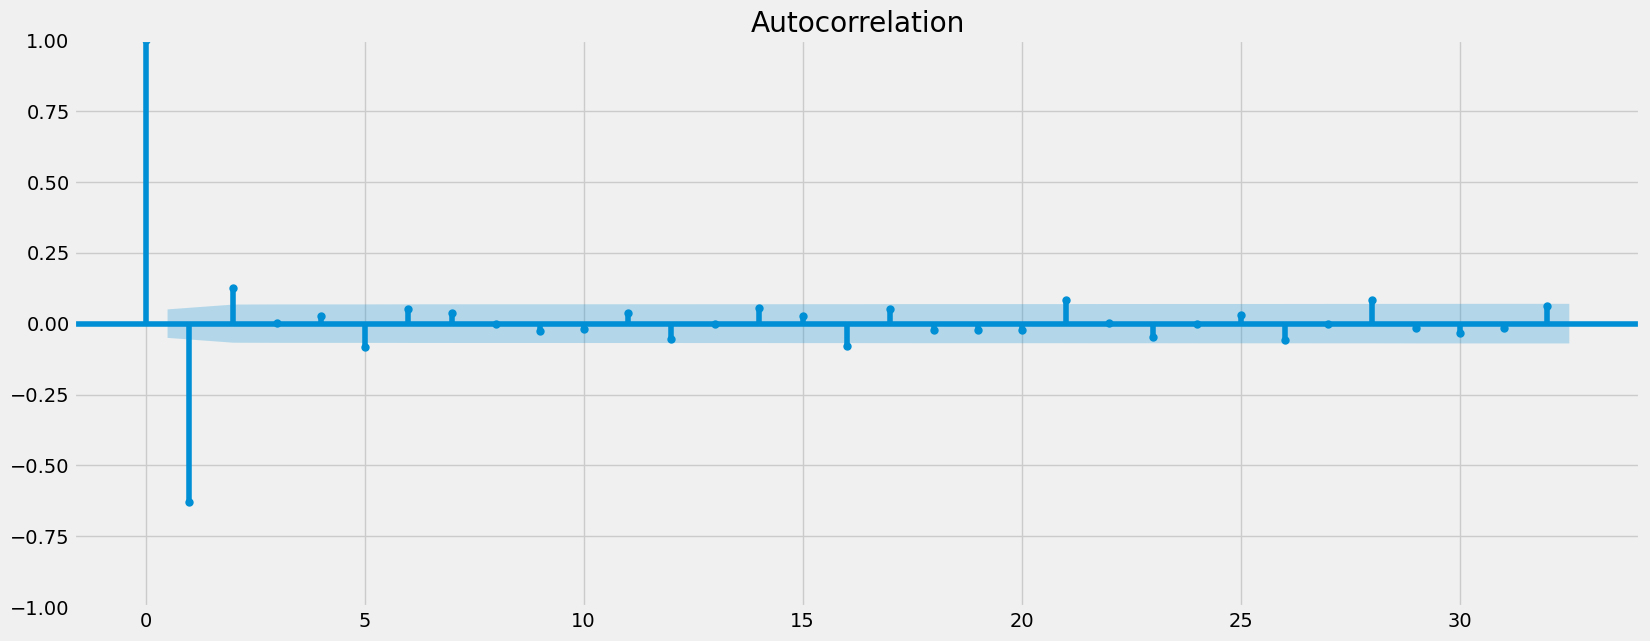

In [55]:
plot_acf(data_diff2)
plt.show()

**Observation:**
The autocorrelation plot has improved with only 7 data points above or below the confidence interval.